<a href="https://www.kaggle.com/code/josmyrose/bank-customer-churn1-1?scriptVersionId=159737134" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# PROBLEM STATEMENT

** **Build an end-to-end  machine learning model to predict whether a customer continue with their account or close it****

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE


In [40]:
from keras.models import Sequential
from keras.layers import Dense

Read the dataset into python environment

In [3]:
df_train=pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
df_submission=pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")




In [5]:
#Details about training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [6]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


**Class Imbalance Exploration: Unveiling the Dataset Composition**

This is a  binary classification problem. The goal is  to develop a model that can predict or classify new instances into one of the two classes based on input features. For instance, in a churn prediction scenario for a business, "Exited"  represent whether a customer churned (1) or did not churn (0). The numbers give an indication of the distribution of the two classes in the dataset.

Understanding the class distribution is crucial in handling imbalanced datasets, where one class may significantly outnumber the other. This could impact the performance of machine learning models, and specialized techniques may be required to address the imbalance, such as oversampling, undersampling, or using specific evaluation metrics designed for imbalanced datasets.


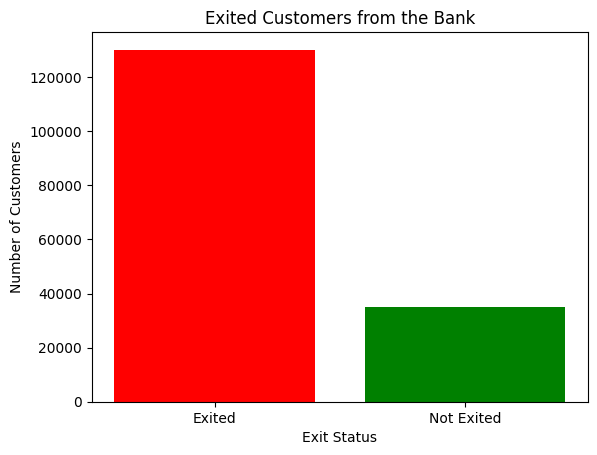

In [7]:
# Count the number of exited and not exited customers
exit_counts = df_train['Exited'].value_counts()

# Create a bar chart
plt.bar(exit_counts.index, exit_counts.values, color=['red', 'green'])
plt.xlabel('Exit Status')
plt.ylabel('Number of Customers')
plt.title('Exited Customers from the Bank')
plt.xticks(exit_counts.index, ['Exited', 'Not Exited'])

# Show the plot
plt.show()

In [14]:
df_train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [15]:
#  To display unique values in each column
for column in df_train.columns[3:]:
    value_counts = df_train[column].nunique()
    print(f"Value counts for {column}:\n{value_counts}")
    print("=" * 30)

Value counts for CreditScore:
457
Value counts for Geography:
3
Value counts for Gender:
2
Value counts for Age:
71
Value counts for Tenure:
11
Value counts for Balance:
30075
Value counts for NumOfProducts:
4
Value counts for HasCrCard:
2
Value counts for IsActiveMember:
2
Value counts for EstimatedSalary:
55298
Value counts for Exited:
2


In [17]:
df_train['Geography'].value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

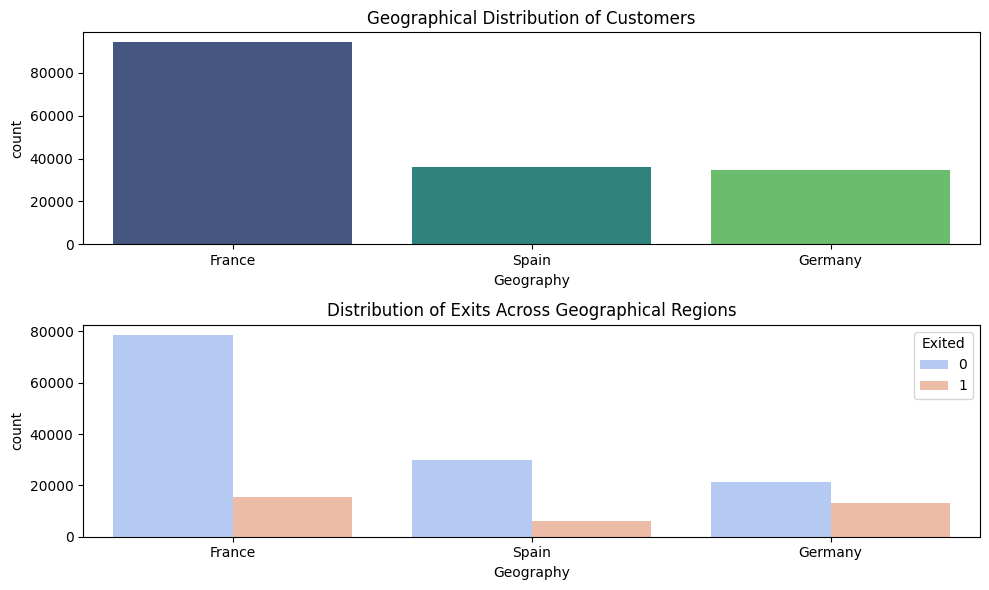

In [19]:
# Explore geographical distribution of customers and exits
plt.figure(figsize=(10, 6))

# Bar chart for the overall geographical distribution
plt.subplot(2, 1, 1)
sns.countplot(x='Geography', data=df_train, palette='viridis')
plt.title('Geographical Distribution of Customers')

# Bar chart for the distribution of exits across geographical regions
plt.subplot(2, 1, 2)
sns.countplot(x='Geography', hue='Exited', data=df_train, palette='coolwarm')
plt.title('Distribution of Exits Across Geographical Regions')
plt.legend(title='Exited', loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
# Create a contingency table
contingency_table = pd.crosstab(df_train['Geography'], df_train['Exited'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant relationship between geography and customer exits.")
else:
    print("There is no significant relationship between geography and customer exits.")

Chi-square value: 7358.673765244894
P-value: 0.0
There is a significant relationship between geography and customer exits.


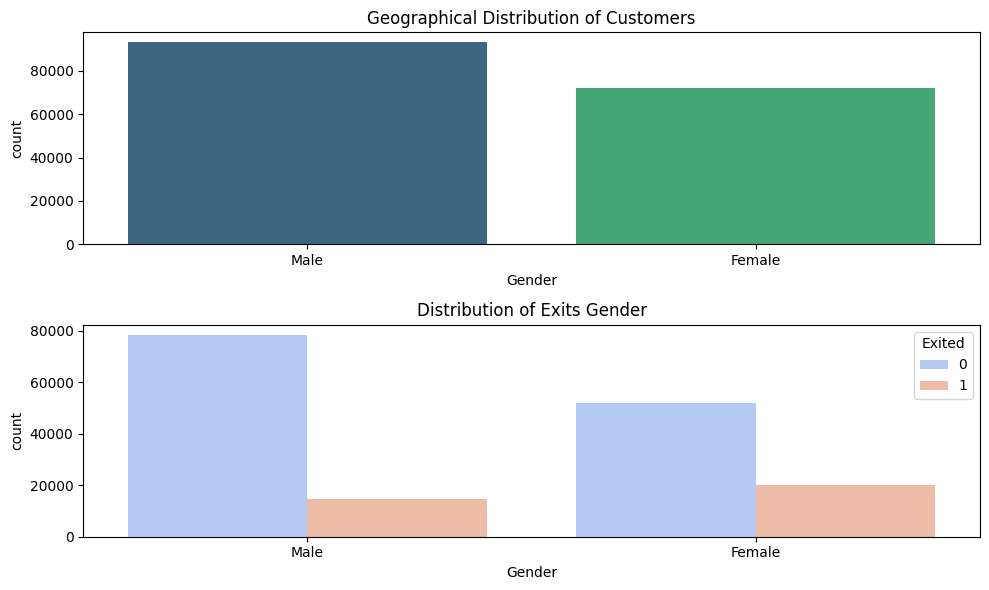

In [25]:
# Explore geographical distribution of customers and exits
plt.figure(figsize=(10, 6))

# Bar chart for the overall geographical distribution
plt.subplot(2, 1, 1)
sns.countplot(x='Gender', data=df_train, palette='viridis')
plt.title('Geographical Distribution of Customers')

# Bar chart for the distribution of exits across geographical regions
plt.subplot(2, 1, 2)
sns.countplot(x='Gender', hue='Exited', data=df_train, palette='coolwarm')
plt.title('Distribution of Exits Gender')
plt.legend(title='Exited', loc='upper right')

plt.tight_layout()
plt.show()

In [27]:
# Create a contingency table
contingency_table = pd.crosstab(df_train['Gender'], df_train['Exited'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant relationship between geography and customer exits.")
else:
    print("There is no significant relationship between geography and customer exits.")

Chi-square value: 3538.4525498496996
P-value: 0.0
There is a significant relationship between geography and customer exits.


In [ ]:
for column in df_train.columns[:-1]:  # Exclude the target column
    contingency_table = pd.crosstab(df_train[column], df_train['Exited'])
   # print(f"\nContingency table for {column}:\n{contingency_table}")

    # Perform the chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"\nChi-square test results for {column}:\nChi2: {chi2}\nP-value: {p}\n{'-'*30}")

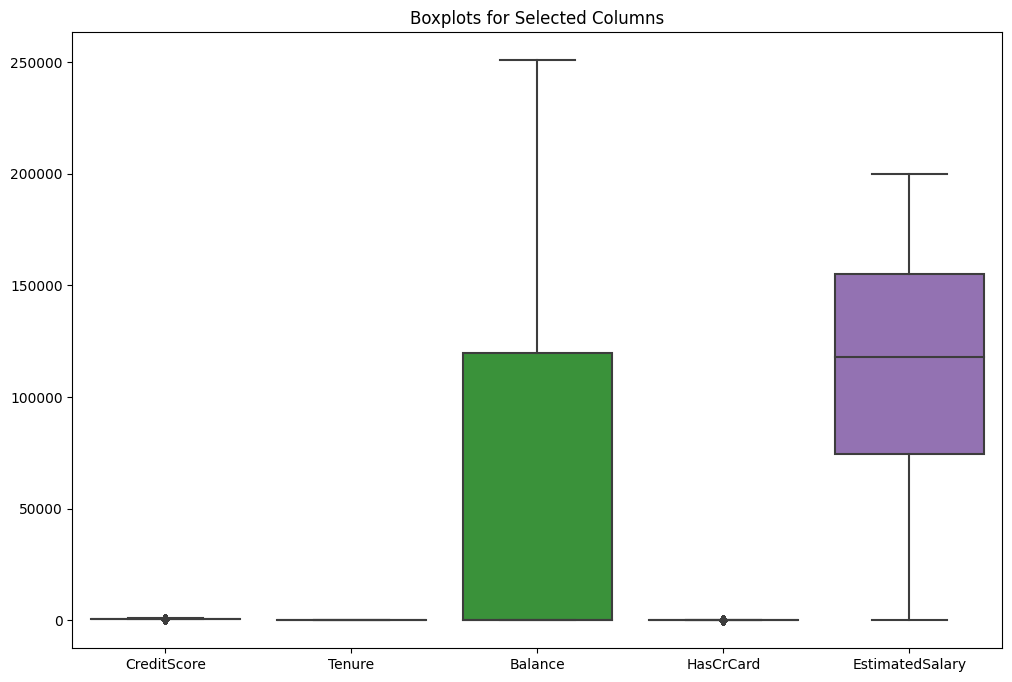

In [29]:
# Assuming 'data' is your DataFrame
columns_to_plot = ['CreditScore', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary']

# Create boxplots for each selected column
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train[columns_to_plot])
plt.title('Boxplots for Selected Columns')
plt.show()

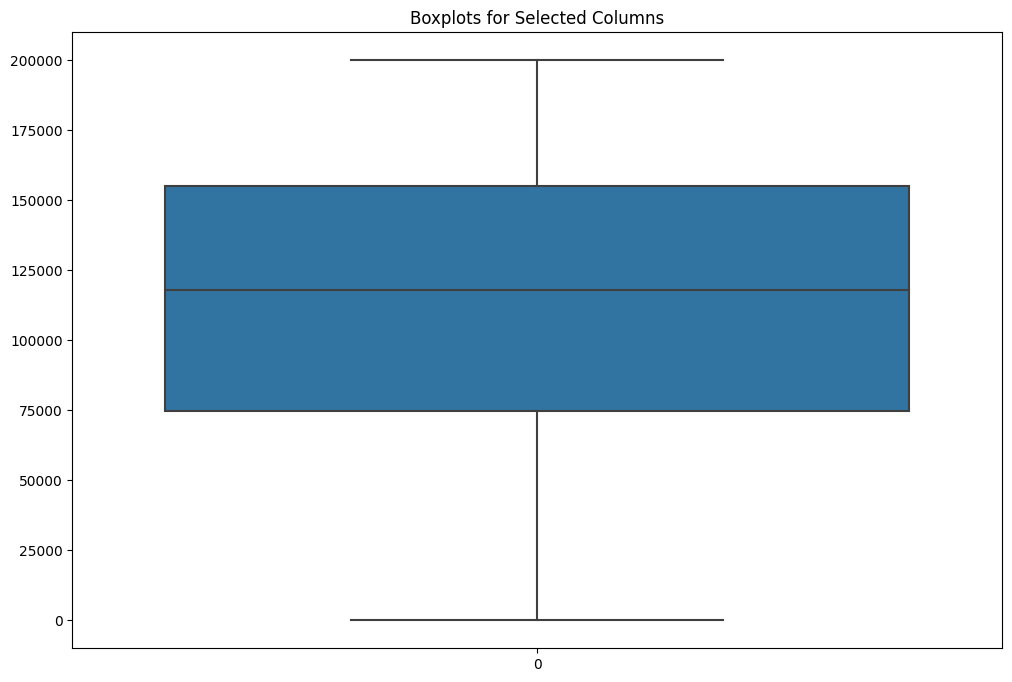

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train['EstimatedSalary'])
plt.title('Boxplots for Selected Columns')
plt.show()

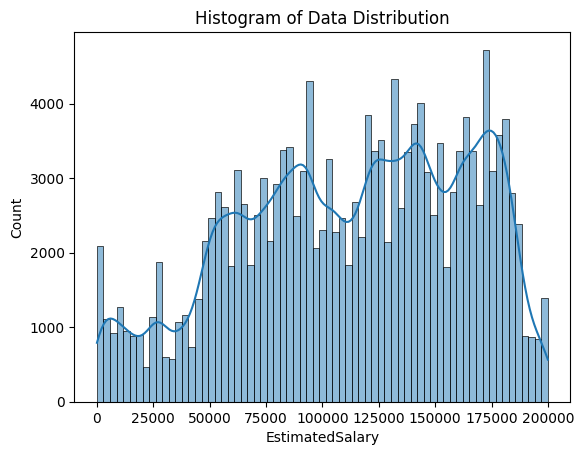

In [32]:
# Assuming 'data' is your DataFrame and 'column' is the column you want to visualize
sns.histplot(data=df_train['EstimatedSalary'], kde=True)
plt.title('Histogram of Data Distribution')
plt.show()

Based on the p value,the following attributes are selected as features for model creation.creditscore,tenure,balance,Hashcard,estimated salary.

In [34]:
X = df_train[['CreditScore', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary']]
y=df_train['Exited']

In [35]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled data to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=[f"feature_{i}" for i in range(X_resampled.shape[1])])
df_resampled['target'] = y_resampled

# Display the class distribution after applying SMOTE
print("\nClass distribution after applying SMOTE:")
print(df_resampled['target'].value_counts())


Class distribution after applying SMOTE:
target
0    130113
1    130113
Name: count, dtype: int64


In [37]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
scaled_data = scaler.fit_transform(X_resampled)

# Print the standardized data
print("Original data:\n",X_resampled)
print("\nStandardized data:\n", scaled_data)

Original data:
         CreditScore  Tenure        Balance  HasCrCard  EstimatedSalary
0               668       3       0.000000   1.000000    181449.970000
1               627       1       0.000000   1.000000     49503.500000
2               678      10       0.000000   1.000000    184866.690000
3               581       2  148882.540000   1.000000     84560.880000
4               716       5       0.000000   1.000000     15068.830000
...             ...     ...            ...        ...              ...
260221          693       3  134322.800265   0.485844    136922.233475
260222          717       3  131198.539400   0.392292    180311.867711
260223          640       4  111447.319709   1.000000    159705.671102
260224          633       4  137960.529042   1.000000    178114.589377
260225          525       5       0.000000   1.000000    175061.900031

[260226 rows x 5 columns]

Standardized data:
 [[ 0.17324737 -0.68736491 -0.96850211  0.61999829  1.35334658]
 [-0.36355022 -1.4431

In [39]:
X_resampled.columns

Index(['CreditScore', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary'], dtype='object')

In [41]:
# Convert the scaled data to a pandas DataFrame with column names
scaled_df = pd.DataFrame(data=scaled_data, columns=X_resampled.columns)

# Display the resulting DataFrame
print(scaled_df)

        CreditScore    Tenure   Balance  HasCrCard  EstimatedSalary
0          0.173247 -0.687365 -0.968502   0.619998         1.353347
1         -0.363550 -1.443173 -0.968502   0.619998        -1.267017
2          0.304174  1.957962 -0.968502   0.619998         1.421200
3         -0.965811 -1.065269  1.386710   0.619998        -0.570802
4          0.801693  0.068443 -0.968502   0.619998        -1.950866
...             ...       ...       ...        ...              ...
260221     0.500563 -0.687365  1.156386  -0.644465         0.469057
260222     0.814786 -0.687365  1.106962  -0.874535         1.330745
260223    -0.193346 -0.309461  0.794513   0.619998         0.921520
260224    -0.284994 -0.309461  1.213932   0.619998         1.287108
260225    -1.698998  0.068443 -0.968502   0.619998         1.226484

[260226 rows x 5 columns]


In [43]:
y=df_resampled['target']

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df,y,test_size=0.2,random_state=42)

In [ ]:
# Define a list of models
models = [
    ('Support Vector Machine', SVC()),
    ('XGBoost', xgb.XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('LightGBM', lgb.LGBMClassifier())
]

# Iterate through the models and train each one
for model_name, model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])

    #conf_matrix = confusion_matrix(y_test, y_pred)
    #classification_rep = classification_report(y_test, y_pred)

    print(model_name)
    print("**************************")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Score: {f1:.4f}")
    #print(f"ROC AUC: {roc_auc:.4f}")

    #print("\nConfusion Matrix:")
    #(conf_matrix)

    #print("\nClassification Report:")
    #print(classification_rep)

**Observations from Model Evaluation Results**

**Support Vector Machine (SVM)**

SVM shows extremely low precision, recall, and F1 Score, suggesting potential issues with model performance.
**XGBoost**

XGBoost exhibits higher precision than recall, with a limited overall F1 Score. This indicates a potential imbalance in the model's ability to capture positive instances.

**Decision Tree**

The Decision Tree model demonstrates relatively balanced precision and recall, resulting in a decent F1 Score. This model seems to be capturing positive instances effectively.

**Random Forest**

Random Forest outperforms XGBoost in terms of precision, recall, and F1 Score, showing better overall performance on the evaluated metrics.

**LightGBM**

LightGBM demonstrates high precision but extremely low recall, resulting in a negligible F1 Score. This indicates challenges in capturing positive instances, potentially leading to false negatives.

LightGBM model is selected for creating model.

**DATA EXPLORATION OF TEST DATASET**

In [ ]:
df_test.info()

In [ ]:
df_test.head()

In [ ]:
#  To display unique values in each column
for column in df_test.columns[3:]:
    value_counts = df_test[column].nunique()
    print(f"Value counts for {column}:\n{value_counts}")
    print("=" * 30)

In [ ]:
df_test.info()

Model created with selected features such as  'CreditScore', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary' based on p value.

In [ ]:
Xtest = df_test[['CreditScore', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary']]

In [ ]:
Xtest.describe()

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
scaled_datatest = scaler.fit_transform(Xtest)

# Print the standardized data
print("Original data:\n",Xtest)
print("\nStandardized data:\n", scaled_datatest)

In [ ]:
# Convert the scaled data to a pandas DataFrame with column names
scaled_dftest = pd.DataFrame(data=scaled_datatest, columns=Xtest.columns)

# Display the resulting DataFrame
print(scaled_dftest)

In [ ]:
model_name="LGBM Classifier"
model1=lgb.LGBMClassifier()
model1.fit(X_train,y_train)
    #pipeline.fit(X_train,y_train)
#score = precision_score(X_test, y_test)
#print(f"{model_name} score Accuracy: {score}")
    #model.fit(X_train, y_train)


In [ ]:
predictions = model1.predict(scaled_dftest)

In [ ]:
df_submission.head()

In [ ]:
predictions1 = model1.predict_proba(Xtest)

In [ ]:
predictions2 = model1.predict(Xtest)

In [ ]:
predictions2

In [ ]:
predictions1 = model1.predict_proba(Xtest)

In [ ]:
y_probs1= model1.predict_proba(Xtest)

In [ ]:
predictions1

In [ ]:
final = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
#final.Status_C = predictions1[:, 0]
#final.Status_CL = predictions1[:, 1]
#final.Status_D = predictions1[:, 2]
final.head()

In [ ]:
final['Exited'] = predictions

In [ ]:
final.to_csv('easy_prototype_sub.csv', index = False)

In [ ]:
final.head(20)

# MODEL CREATION USING ALL THE ESSENTIAL FEATURES IN THE DATASET 

**Analysis of training dataset**

In [8]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [10]:
 df_train.drop(columns=['id','CustomerId','Surname'],inplace=True,axis=1)

KeyError: "['id', 'CustomerId', 'Surname'] not found in axis"

In [12]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Check whether the null value is present in the dataset

In [13]:
for column in df_train.columns:
    null_count = df_train[column].isnull().sum()
    print(f"Column '{column}' has {null_count} null values.")

Column 'CreditScore' has 0 null values.
Column 'Geography' has 0 null values.
Column 'Gender' has 0 null values.
Column 'Age' has 0 null values.
Column 'Tenure' has 0 null values.
Column 'Balance' has 0 null values.
Column 'NumOfProducts' has 0 null values.
Column 'HasCrCard' has 0 null values.
Column 'IsActiveMember' has 0 null values.
Column 'EstimatedSalary' has 0 null values.
Column 'Exited' has 0 null values.


In [15]:
Xtarin=df_train.drop('Exited',axis=1)

In [17]:
Ytrain=df_train['Exited']

In [42]:
#numerical_features = ['numerical_col1', 'numerical_col2']
#categorical_features = ['categorical_col1', 'categorical_col2']
categorical_features  = Xtarin.select_dtypes(include=['object']).columns
numerical_features = Xtarin.select_dtypes(include=['number']).columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline with the column transformer
# You can add additional steps (e.g., a machine learning model) to the pipeline as needed
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform your data
transformed_data = pipeline.fit_transform(Xtarin)

In [20]:
transformed_data

array([[ 0.14413459, -0.57807434, -0.71997339, ...,  0.        ,
         0.        ,  1.        ],
       [-0.36770579, -0.57807434, -1.43269365, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2689737 ,  0.21135385,  1.77454751, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.14170832, -0.80362525, -0.00725313, ...,  0.        ,
         0.        ,  1.        ],
       [-1.27903135, -0.9164007 ,  0.70546712, ...,  1.        ,
         1.        ,  0.        ],
       [ 2.41620652, -0.80362525, -1.43269365, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
transformed_data.head()

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_data ,Ytrain,test_size=0.2,random_state=42)

array([[ 1.76704311, -0.80362525,  1.06182725, ...,  0.        ,
         1.        ,  0.        ],
       [-0.34273797, -1.36750252,  0.349107  , ...,  0.        ,
         0.        ,  1.        ],
       [-1.14170832,  0.09857839,  0.70546712, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.38004185, -0.35252343,  0.70546712, ...,  0.        ,
         1.        ,  0.        ],
       [-0.04312409, -0.57807434,  1.41818738, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87954617,  0.54968021, -0.00725313, ...,  1.        ,
         1.        ,  0.        ]])

In [24]:
# Define a list of models
models = [
    ('Support Vector Machine', SVC()),
    ('XGBoost', xgb.XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('LightGBM', lgb.LGBMClassifier())
]

# Iterate through the models and train each one
for model_name, model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])
    print(model_name)
    print("**************************")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Score: {f1:.4f}")

Support Vector Machine
**************************
Precision: 0.7784
Recall: 0.4919
F1 Score: 0.6028
F1 Score: 0.6028
XGBoost
**************************
Precision: 0.7375
Recall: 0.5668
F1 Score: 0.6410
F1 Score: 0.6410
Decision Tree
**************************
Precision: 0.5178
Recall: 0.5396
F1 Score: 0.5285
F1 Score: 0.5285
Random Forest
**************************
Precision: 0.7192
Recall: 0.5390
F1 Score: 0.6162
F1 Score: 0.6162
LightGBM
**************************
Precision: 0.7451
Recall: 0.5652
F1 Score: 0.6428
F1 Score: 0.6428


In [31]:

model1=SVC()
model1.fit(X_train,y_train)

SVC()

**Analysis of Test Dataset**

In [25]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [27]:
df_test.drop(columns=['id','CustomerId','Surname'],inplace=True,axis=1)

KeyError: "['id', 'CustomerId', 'Surname'] not found in axis"

In [28]:
df_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [29]:
for column in df_test.columns:
    null_count = df_test[column].isnull().sum()
    print(f"count null values of '{column}' has {null_count} ")

count null values of 'CreditScore' has 0 
count null values of 'Geography' has 0 
count null values of 'Gender' has 0 
count null values of 'Age' has 0 
count null values of 'Tenure' has 0 
count null values of 'Balance' has 0 
count null values of 'NumOfProducts' has 0 
count null values of 'HasCrCard' has 0 
count null values of 'IsActiveMember' has 0 
count null values of 'EstimatedSalary' has 0 


In [44]:
#numerical_features = ['numerical_col1', 'numerical_col2']
#categorical_features = ['categorical_col1', 'categorical_col2']
categorical_features  = df_test.select_dtypes(include=['object']).columns
numerical_features = df_test.select_dtypes(include=['number']).columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline with the column transformer
# You can add additional steps (e.g., a machine learning model) to the pipeline as needed
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform your data
transformed_data1 = pipeline.fit_transform(df_test)

In [35]:
predictions3 = model1.predict(transformed_data)

In [36]:
final1 = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
#final.Status_C = predictions1[:, 0]
#final.Status_CL = predictions1[:, 1]
#final.Status_D = predictions1[:, 2]
final1.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [38]:
final1['Exited'] = predictions3

In [39]:
final1.to_csv('easy_prototype_sub.csv', index = False)

**NEURAL NETWORK**

# **#Neural network Model creation for test dataset**

In [41]:
# Build a simple neural network model
model = Sequential()
model.add(Dense(64, input_dim=transformed_data.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the resampled data
model.fit(transformed_data,Ytrain, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)

Epoch 1/10
2751/2751 [==============================] - 7s 2ms/step - loss: 0.5215 - accuracy: 0.7851 - val_loss: 0.5100 - val_accuracy: 0.7940
Epoch 2/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5177 - accuracy: 0.7880 - val_loss: 0.5108 - val_accuracy: 0.7940
Epoch 3/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5173 - accuracy: 0.7880 - val_loss: 0.5100 - val_accuracy: 0.7940
Epoch 4/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5169 - accuracy: 0.7880 - val_loss: 0.5097 - val_accuracy: 0.7940
Epoch 5/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5166 - accuracy: 0.7880 - val_loss: 0.5092 - val_accuracy: 0.7940
Epoch 6/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5165 - accuracy: 0.7880 - val_loss: 0.5091 - val_accuracy: 0.7940
Epoch 7/10
2751/2751 [==============================] - 6s 2ms/step - loss: 0.5165 - accuracy: 0.7880 - val_loss: 0.5107 - val_accuracy:

In [45]:
predictions3 = model.predict(transformed_data1)

3439/3439 [==============================] - 4s 1ms/step


In [46]:
final2 = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
#final.Status_C = predictions1[:, 0]
#final.Status_CL = predictions1[:, 1]
#final.Status_D = predictions1[:, 2]
final2.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [ ]:
final2['Exited'] = predictions3

In [47]:
final2.to_csv('easy_prototype_sub1.csv', index = False)